# Employee Attrition Prediction

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Compile](#Compile)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [6]:
bucket = 'sapient-people-analytics-poc'
prefix = 'sagemaker/xgboost-attrition-prediction'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [7]:
!pip install cufflinks --upgrade

Requirement already up-to-date: cufflinks in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (0.16)
Requirement not upgraded as not directly required: ipywidgets>=7.0.0 in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (from cufflinks) (7.4.0)
Requirement not upgraded as not directly required: setuptools>=34.4.1 in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (from cufflinks) (39.1.0)
Requirement not upgraded as not directly required: numpy>=1.9.2 in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (from cufflinks) (1.14.3)
Requirement not upgraded as not directly required: ipython>=5.3.0 in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (from cufflinks) (6.4.0)
Requirement not upgraded as not directly required: six>=1.9.0 in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (from cufflinks) (1.12.0)
Requirement not upgraded as not directly required: plo

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for plotting graphs
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer
import plotly
import plotly.plotly as py
import plotly.offline as off
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True)

off.init_notebook_mode(connected=True)

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [9]:
!aws s3 cp s3://sapient-people-analytics-poc/sagemaker/Employee-Attrition.csv ./

download: s3://sapient-people-analytics-poc/sagemaker/Employee-Attrition.csv to ./Employee-Attrition.csv


In [10]:
attrition = pd.read_csv('./Employee-Attrition.csv')
pd.set_option('display.max_columns', 500)
attrition

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,4,Male,67,3,1,Laboratory Technician,3,Divorced,2693,13335,1,Y,No,22,4,2,80,1,1,2,3,1,0,0,0
8,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,4,Male,44,2,3,Manufacturing Director,3,Single,9526,8787,0,Y,No,21,4,2,80,0,10,2,3,9,7,1,8
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,3,Male,94,3,2,Healthcare Representative,3,Married,5237,16577,6,Y,No,13,3,2,80,2,17,3,2,7,7,7,7


In [11]:
attrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

In [12]:
# Frequency tables for each categorical feature
for column in attrition.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=attrition[column], columns='% observations', normalize='columns'))

col_0,% observations
Attrition,
No,0.838776
Yes,0.161224


col_0,% observations
BusinessTravel,
Non-Travel,0.102041
Travel_Frequently,0.188435
Travel_Rarely,0.709524


col_0,% observations
Department,
Human Resources,0.042857
Research & Development,0.653741
Sales,0.303401


col_0,% observations
EducationField,
Human Resources,0.018367
Life Sciences,0.412245
Marketing,0.108163
Medical,0.315646
Other,0.055782
Technical Degree,0.089796


col_0,% observations
Gender,
Female,0.4
Male,0.6


col_0,% observations
JobRole,
Healthcare Representative,0.089116
Human Resources,0.035374
Laboratory Technician,0.176190
Manager,0.069388
Manufacturing Director,0.098639
Research Director,0.054422
Research Scientist,0.198639
Sales Executive,0.221769
Sales Representative,0.056463


col_0,% observations
MaritalStatus,
Divorced,0.222449
Married,0.457823
Single,0.319728


col_0,% observations
Over18,
Y,1.0


col_0,% observations
OverTime,
No,0.717007
Yes,0.282993


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


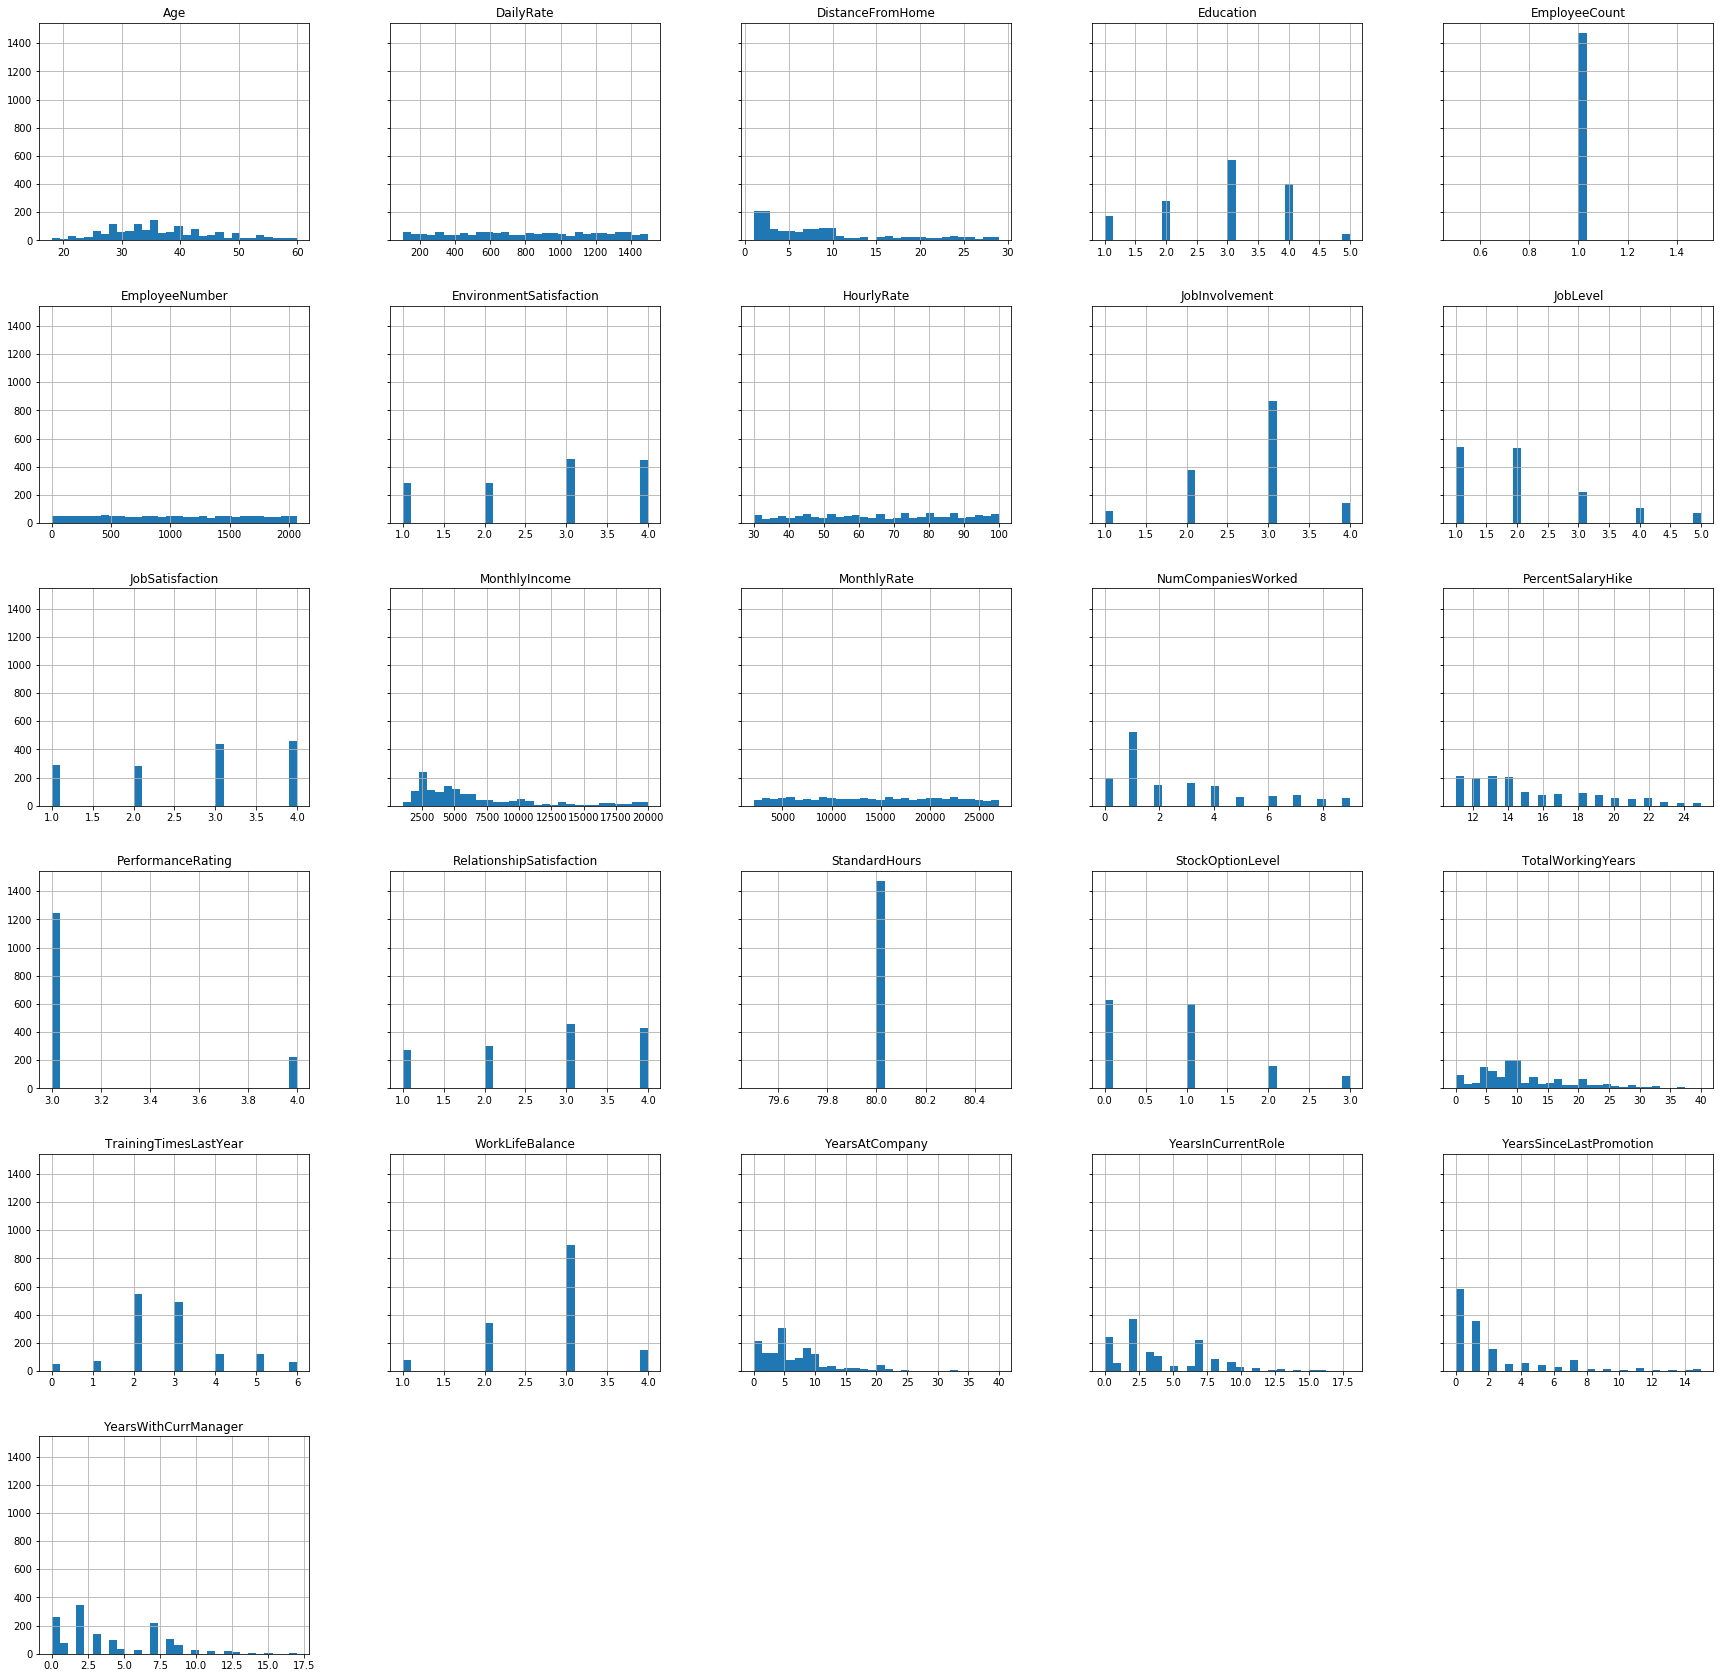

In [13]:
# Histograms for each numeric features
display(attrition.describe())
# %matplotlib inline
hist = attrition.hist(bins=30, sharey=True, figsize=(30, 30))

In [14]:
attrition.groupby('Attrition').mean()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,,,,,,,,
No,37.561233,812.504461,8.915653,2.927007,1.0,1027.656123,2.771290,65.952149,2.770479,2.145985,2.778589,6832.739659,14265.779400,2.645580,15.231144,3.153285,2.733982,80.0,0.845093,11.862936,2.832928,2.781022,7.369019,4.484185,2.234388,4.367397
Yes,33.607595,750.362869,10.632911,2.839662,1.0,1010.345992,2.464135,65.573840,2.518987,1.637131,2.468354,4787.092827,14559.308017,2.940928,15.097046,3.156118,2.599156,80.0,0.527426,8.244726,2.624473,2.658228,5.130802,2.902954,1.945148,2.852321


In [15]:
attrition['EducationField'].value_counts()

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

In [16]:
df_Education = pd.DataFrame(columns=["Field", "% of Leavers"])
i=0
for field in list(attrition['EducationField'].unique()):
    percentage = attrition[(attrition['EducationField']==field)&(attrition['Attrition']=="Yes")].shape[0]*100 / attrition[attrition['EducationField']==field].shape[0]    
    df_Education.loc[i] = (field, percentage)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, percentage))    
df_EF = df_Education.groupby(by="Field").sum()
df_EF.iplot(kind='bar',title='Leavers by Education Field (%)')

In [17]:
df_Gender = pd.DataFrame(columns=["Field", "% of Leavers"])
i=0
for field in list(attrition['Gender'].unique()):
    percentage = attrition[(attrition['Gender']==field)&(attrition['Attrition']=="Yes")].shape[0]*100 / attrition[attrition['Gender']==field].shape[0]    
    df_Gender.loc[i] = (field, percentage)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, percentage))    
df_EF = df_Gender.groupby(by="Field").sum()
df_EF.iplot(kind='bar',title='Leavers by Gender (%)')

In [18]:
df_Marital = pd.DataFrame(columns=["Marital Status", "% of Leavers"])
i=0
for field in list(attrition['MaritalStatus'].unique()):
    ratio = attrition[(attrition['MaritalStatus']==field)&(attrition['Attrition']=="Yes")].shape[0]*100 / attrition[attrition['MaritalStatus']==field].shape[0]
    df_Marital.loc[i] = (field, ratio)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_MF = df_Marital.groupby(by="Marital Status").sum()
df_MF.iplot(kind='bar',title='Leavers by Marital Status (%)')

Above graphs shows that attrition rate is more for people with Single status.

In [19]:
# Distance from Home
print("Distance from home for employees to get to work is from {} to {} miles.".format(attrition['DistanceFromHome'].min(),
                                                                                       attrition['DistanceFromHome'].max()))

Distance from home for employees to get to work is from 1 to 29 miles.


In [20]:
print('Average distance from home for currently active employees: {:.2f} miles and ex-employees: {:.2f} miles'.format(
    attrition[attrition['Attrition'] == 'No']['DistanceFromHome'].mean(), attrition[attrition['Attrition'] == 'Yes']['DistanceFromHome'].mean()))

Average distance from home for currently active employees: 8.92 miles and ex-employees: 10.63 miles


Distance from home for employees to get to work varies from 1 to 29 miles. There is no discernable strong correlation between Distance from Home and Attrition Status as per the KDE plot below. However we can see that when distance increases number of employees who are currently working decreases in comparison to ex employees.

In [21]:
# Add histogram data
x1 = attrition.loc[attrition['Attrition'] == 'No', 'DistanceFromHome']
x2 = attrition.loc[attrition['Attrition'] == 'Yes', 'DistanceFromHome']
# Group data together
hist_data = [x1, x2]
group_labels = ['Active Employees', 'Ex-Employees']
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,
                         curve_type='kde', show_hist=False, show_rug=False)
# Add title
fig['layout'].update(
    title='Distance From Home Distribution in Percent by Attrition Status')
fig['layout'].update(xaxis=dict(range=[0, 30], dtick=2))
# Plot
off.iplot(fig, filename='Distplot with Multiple Datasets')

Text(0, 0.5, 'Attrition')

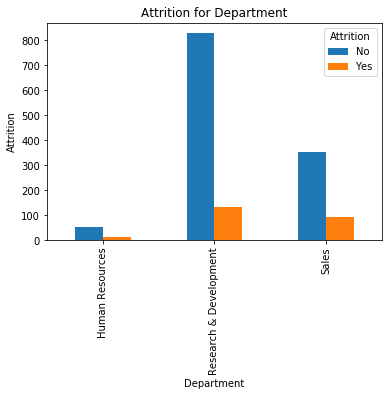

In [22]:
pd.crosstab(attrition.Department,attrition.Attrition).plot(kind='bar')
plt.title('Attrition for Department')
plt.xlabel('Department')
plt.ylabel('Attrition')
#plt.savefig('department_bar_chart')

In [23]:
df_Department = pd.DataFrame(columns=["Department", "% of Leavers"])
i=0
for field in list(attrition['Department'].unique()):
    ratio = attrition[(attrition['Department']==field)&(attrition['Attrition']=="Yes")].shape[0] * 100/ attrition[attrition['Department']==field].shape[0]
    df_Department.loc[i] = (field, ratio)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_DF = df_Department.groupby(by="Department").sum()
df_DF.iplot(kind='bar',title='Leavers by Department (%)')

In [24]:
df_BusinessTravel = pd.DataFrame(columns=["Business Travel", "% of Leavers"])
i=0
for field in list(attrition['BusinessTravel'].unique()):
    ratio = attrition[(attrition['BusinessTravel']==field)&(attrition['Attrition']=="Yes")].shape[0]*100 / attrition[attrition['BusinessTravel']==field].shape[0]
    df_BusinessTravel.loc[i] = (field, ratio)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_BT = df_BusinessTravel.groupby(by="Business Travel").sum()
df_BT.iplot(kind='bar',title='Leavers by Business Travel (%)')

In [25]:
df_JobRole = pd.DataFrame(columns=["Job Role", "% of Leavers"])
i=0
for field in list(attrition['JobRole'].unique()):
    ratio = attrition[(attrition['JobRole']==field)&(attrition['Attrition']=="Yes")].shape[0]*100 / attrition[attrition['JobRole']==field].shape[0]
    df_JobRole.loc[i] = (field, ratio)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_JR = df_JobRole.groupby(by="Job Role").sum()
df_JR.iplot(kind='bar',title='Leavers by Job Role (%)')

In [26]:
df_JobLevel = pd.DataFrame(columns=["Job Level", "% of Leavers"])
i=0
for field in list(attrition['JobLevel'].unique()):
    ratio = attrition[(attrition['JobLevel']==field)&(attrition['Attrition']=="Yes")].shape[0]*100 / attrition[attrition['JobLevel']==field].shape[0]
    df_JobLevel.loc[i] = (field, ratio)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_JL = df_JobLevel.groupby(by="Job Level").sum()
df_JL.iplot(kind='bar',title='Leavers by Job Level (%)')

In [27]:
# Add histogram data
x1 = attrition.loc[attrition['Attrition'] == 'No', 'TrainingTimesLastYear']
x2 = attrition.loc[attrition['Attrition'] == 'Yes', 'TrainingTimesLastYear']
# Group data together
hist_data = [x1, x2]
group_labels = ['Active Employees', 'Ex-Employees']
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,
                         curve_type='kde', show_hist=False, show_rug=False)
# Add title
fig['layout'].update(
    title='Training Times Last Year metric in Percent by Attrition Status')
fig['layout'].update(xaxis=dict(range=[0, attrition['TrainingTimesLastYear'].max()], dtick=1))
# Plot
off.iplot(fig, filename='Distplot with Multiple Datasets')

Above analysis doesn't give any information of impact of training hours on attrition. So we can ignore this attribute.

In [28]:
df_NumCompaniesWorked = pd.DataFrame(columns=["Num Companies Worked", "% of Leavers"])
i=0
for field in list(attrition['NumCompaniesWorked'].unique()):
    ratio = attrition[(attrition['NumCompaniesWorked']==field)&(attrition['Attrition']=="Yes")].shape[0]*100 / attrition[attrition['NumCompaniesWorked']==field].shape[0]
    df_NumCompaniesWorked.loc[i] = (field, ratio)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_NC = df_NumCompaniesWorked.groupby(by="Num Companies Worked").sum()
df_NC.iplot(kind='bar',title='Leavers by Num Companies Worked (%)')

In [29]:
print('Average Number of Years at the company for currently active employees: {:.2f} miles and ex-employees: {:.2f} years'.format(
    attrition[attrition['Attrition'] == 'No']['YearsAtCompany'].mean(), attrition[attrition['Attrition'] == 'Yes']['YearsAtCompany'].mean()))

Average Number of Years at the company for currently active employees: 7.37 miles and ex-employees: 5.13 years


In [30]:
# Add histogram data
x1 = attrition.loc[attrition['Attrition'] == 'No', 'YearsAtCompany']
x2 = attrition.loc[attrition['Attrition'] == 'Yes', 'YearsAtCompany']
# Group data together
hist_data = [x1, x2]
group_labels = ['Active Employees', 'Ex-Employees']
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,
                         curve_type='kde', show_hist=False, show_rug=False)
# Add title
fig['layout'].update(title='Years At Company in Percent by Attrition Status')
fig['layout'].update(xaxis=dict(range=[0, attrition['YearsAtCompany'].max()], dtick=5))
# Plot
off.iplot(fig, filename='Distplot with Multiple Datasets')

Again from above analysis also we cann't draw any concreate conclusion on relationship between attrition and years of experience in the company.  

In [31]:
print("Number of Years in the current role varies from {} to {} years.".format(
    attrition['YearsInCurrentRole'].min(), attrition['YearsInCurrentRole'].max()))

Number of Years in the current role varies from 0 to 18 years.


In [32]:
x1 = attrition.loc[attrition['Attrition'] == 'No', 'YearsInCurrentRole']
x2 = attrition.loc[attrition['Attrition'] == 'Yes', 'YearsInCurrentRole']
# Group data together
hist_data = [x1, x2]
group_labels = ['Active Employees', 'Ex-Employees']
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,
                         curve_type='kde', show_hist=False, show_rug=False)
# Add title
fig['layout'].update(title='Years InCurrent Role in Percent by Attrition Status')
fig['layout'].update(xaxis=dict(range=[0, attrition['YearsInCurrentRole'].max()], dtick=1))
# Plot
off.iplot(fig, filename='Distplot with Multiple Datasets')

In [33]:
# Add histogram data
x1 = attrition.loc[attrition['Attrition'] == 'No', 'YearsSinceLastPromotion']
x2 = attrition.loc[attrition['Attrition'] == 'Yes', 'YearsSinceLastPromotion']
# Group data together
hist_data = [x1, x2]
group_labels = ['Active Employees', 'Ex-Employees']
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,
                         curve_type='kde', show_hist=False, show_rug=False)
# Add title
fig['layout'].update(title='Years Since Last Promotion in Percent by Attrition Status')
fig['layout'].update(xaxis=dict(range=[0, attrition['YearsSinceLastPromotion'].max()], dtick=1))
# Plot
off.iplot(fig, filename='Distplot with Multiple Datasets')

In [34]:
df_WorkLifeBalance = pd.DataFrame(columns=["WorkLifeBalance", "% of Leavers"])
i=0
for field in list(attrition['WorkLifeBalance'].unique()):
    ratio = attrition[(attrition['WorkLifeBalance']==field)&(attrition['Attrition']=="Yes")].shape[0] * 100/ attrition[attrition['WorkLifeBalance']==field].shape[0]
    df_WorkLifeBalance.loc[i] = (field, ratio)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_WLB = df_WorkLifeBalance.groupby(by="WorkLifeBalance").sum()
df_WLB.iplot(kind='bar',title='Leavers by WorkLifeBalance (%)')

In [35]:
df_PerformanceRating = pd.DataFrame(columns=["PerformanceRating", "% of Leavers"])
i=0
for field in list(attrition['PerformanceRating'].unique()):
    ratio = attrition[(attrition['PerformanceRating']==field)&(attrition['Attrition']=="Yes")].shape[0] *100/ attrition[attrition['PerformanceRating']==field].shape[0]
    df_PerformanceRating.loc[i] = (field, ratio)
    i += 1
    #print("In {}, the ratio of leavers is {:.2f}%".format(field, ratio*100))    
df_PR = df_PerformanceRating.groupby(by="PerformanceRating").sum()
df_PR.iplot(kind='bar',title='Leavers by Performance Rating (%)')

In [36]:
# Add histogram data
x1 = attrition.loc[attrition['Attrition'] == 'No', 'MonthlyIncome']
x2 = attrition.loc[attrition['Attrition'] == 'Yes', 'MonthlyIncome']
# Group data together
hist_data = [x1, x2]
group_labels = ['Active Employees', 'Ex-Employees']
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,
                         curve_type='kde', show_hist=False, show_rug=False)
# Add title
fig['layout'].update(title='Monthly Income by Attrition Status')
fig['layout'].update(xaxis=dict(range=[0, attrition['MonthlyIncome'].max()], dtick=2000))
# Plot
off.iplot(fig, filename='Distplot with Multiple Datasets')

Compensation Analysis:
Salary of an employee is normaly proportional to the job level, Experience, Education etc.
At every level their is a salary band i.e. the range of salary offered specific to that level
In General Salary band at each level shouldn’t overlap much with the nextlevel salary band
Now since salary is determined by the job level of the person we have to find a way to use monthly data in more useful way i.e. salary has to be observed relative to level in which that employee is

Compensation expert will suggest that we should use Compa Ratio to find the relative indicator of salary at each level

Compa Ratio: A Compa-Ratio of 1.00 or 100% means that the employee is paid exactly what the industry average pays and is at the midpoint for the salary range, A ratio of 0.75 means that the employee is paid 25% below the industry average and is at the risk of seeking employment with competitors at a higher pay that is perceived .

An employee doing administrative/back office job would be happy to get INR 30,000 take home considering the median for that group while a manager or business unit head, on the other hand, might not be given the median manager salary at that level of roughly INR 1.5 Lakh.So employee satisfaction also depends on the salary of that employee at respective level

This suggests that looking at salary relative to the median of an employee’s role/level (using compa ratio) makes more sense and will add value to the overall model

To do this, we’ll first calculate the median salary for each group and then create a new salary measure that measures a salary relative to that employee’s role median.

In [37]:
def monthlyIncomeRange(mnthlyIncMedian,mnthlyInc):
    if mnthlyInc > (mnthlyIncMedian+(mnthlyIncMedian*0.2)):
        return 'HIGH'
    elif mnthlyInc < (mnthlyIncMedian-(mnthlyIncMedian*0.2)):
        return 'LOW'
    else:
        return 'MID'
#print(attrition.groupby(['JobLevel','JobRole'])[['MonthlyIncome']].agg('median'))
df_medianSalary = attrition.groupby(['JobLevel','JobRole'])[['MonthlyIncome']].agg('median')
df_medianSalary = df_medianSalary.rename(columns={'MonthlyIncome':'MnthlyIncMedianJobLvlJobRole'})
df_merge_attrition = pd.merge(attrition, df_medianSalary, on=['JobLevel','JobRole'])
df_merge_attrition['MnthlyIncRange'] = df_merge_attrition.apply(lambda x : monthlyIncomeRange(x['MnthlyIncMedianJobLvlJobRole'],x['MonthlyIncome']),axis=1)
df_merge_attrition

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,MnthlyIncMedianJobLvlJobRole,MnthlyIncRange
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,5454.0,MID
1,42,No,Travel_Rarely,691,Sales,8,4,Marketing,1,35,3,Male,48,3,2,Sales Executive,2,Married,6825,21173,0,Y,No,11,3,4,80,1,10,2,3,9,7,4,2,5454.0,HIGH
2,33,No,Travel_Frequently,1141,Sales,1,3,Life Sciences,1,52,3,Female,42,4,2,Sales Executive,1,Married,5376,3193,2,Y,No,19,3,1,80,2,10,3,3,5,3,1,3,5454.0,MID
3,34,No,Non-Travel,1065,Sales,23,4,Marketing,1,60,2,Male,72,3,2,Sales Executive,3,Single,4568,10034,0,Y,No,20,4,3,80,0,10,2,3,9,5,8,7,5454.0,MID
4,46,No,Travel_Frequently,1211,Sales,5,4,Marketing,1,62,1,Male,98,3,2,Sales Executive,4,Single,5772,20445,4,Y,Yes,21,4,3,80,0,14,4,3,9,6,0,8,5454.0,MID
5,44,No,Travel_Rarely,1488,Sales,1,5,Marketing,1,68,2,Female,75,3,2,Sales Executive,1,Divorced,5454,4009,5,Y,Yes,21,4,3,80,1,9,2,2,4,3,1,3,5454.0,MID
6,26,No,Travel_Rarely,1443,Sales,23,3,Marketing,1,72,3,Female,47,2,2,Sales Executive,4,Married,4157,21436,7,Y,Yes,19,3,3,80,1,5,2,2,2,2,0,0,5454.0,LOW
7,59,No,Travel_Frequently,1225,Sales,1,1,Life Sciences,1,91,1,Female,57,2,2,Sales Executive,3,Single,5473,24668,7,Y,No,11,3,4,80,0,20,2,2,4,3,1,3,5454.0,MID
8,35,No,Travel_Rarely,776,Sales,1,4,Marketing,1,100,3,Male,32,2,2,Sales Executive,1,Single,4312,23016,0,Y,No,14,3,2,80,0,16,2,3,15,13,2,8,5454.0,LOW
9,51,No,Travel_Rarely,632,Sales,21,4,Marketing,1,120,3,Male,71,3,2,Sales Executive,4,Single,5441,8423,0,Y,Yes,22,4,4,80,0,11,2,1,10,7,1,0,5454.0,MID


Text(0, 0.5, 'Proportion of Employees')

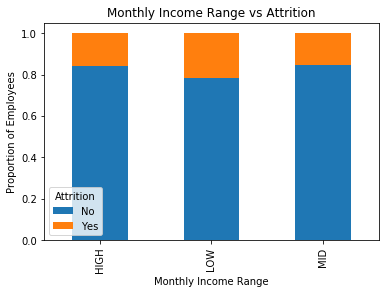

In [38]:
table=pd.crosstab(df_merge_attrition.MnthlyIncRange, df_merge_attrition.Attrition)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Monthly Income Range vs Attrition')
plt.xlabel('Monthly Income Range')
plt.ylabel('Proportion of Employees')

Total employees in ['Sales'] department = 446


Text(0, 0.5, 'Proportion of Employees')

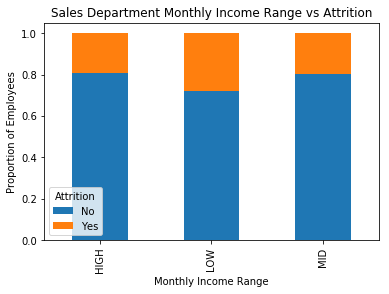

In [39]:
df_merge_attrition_department = df_merge_attrition.loc[df_merge_attrition['Department']=='Sales']
print("Total employees in {} department = {}".format(
    df_merge_attrition_department['Department'].unique(), df_merge_attrition_department.Attrition.count()))

#print(df_merge_attrition_department.Attrition.count())
table=pd.crosstab(df_merge_attrition_department.MnthlyIncRange, df_merge_attrition_department.Attrition)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Sales Department Monthly Income Range vs Attrition')
plt.xlabel('Monthly Income Range')
plt.ylabel('Proportion of Employees')

Total employees in ['Human Resources'] department = 63


Text(0, 0.5, 'Proportion of Employees')

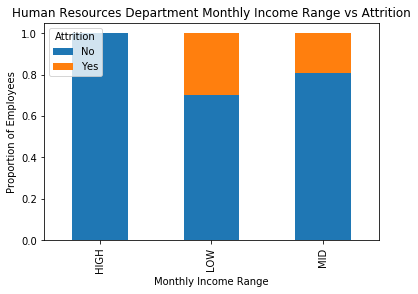

In [40]:
df_merge_attrition_department = df_merge_attrition.loc[df_merge_attrition['Department']=='Human Resources']
print("Total employees in {} department = {}".format(
    df_merge_attrition_department['Department'].unique(), df_merge_attrition_department.Attrition.count()))

#print(df_merge_attrition_department.Attrition.count())
table=pd.crosstab(df_merge_attrition_department.MnthlyIncRange, df_merge_attrition_department.Attrition)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Human Resources Department Monthly Income Range vs Attrition')
plt.xlabel('Monthly Income Range')
plt.ylabel('Proportion of Employees')

Total employees in ['Research & Development'] department = 961


Text(0, 0.5, 'Proportion of Employees')

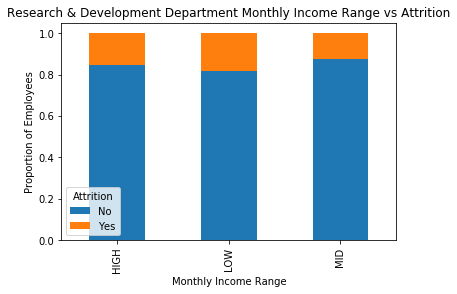

In [41]:
df_merge_attrition_department = df_merge_attrition.loc[df_merge_attrition['Department']=='Research & Development']
print("Total employees in {} department = {}".format(
    df_merge_attrition_department['Department'].unique(), df_merge_attrition_department.Attrition.count()))

#print(df_merge_attrition_department.Attrition.count())
table=pd.crosstab(df_merge_attrition_department.MnthlyIncRange, df_merge_attrition_department.Attrition)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Research & Development Department Monthly Income Range vs Attrition')
plt.xlabel('Monthly Income Range')
plt.ylabel('Proportion of Employees')

Text(0, 0.5, 'Proportion of Employees')

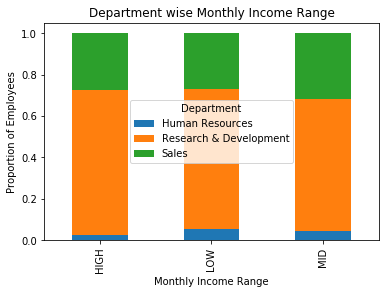

In [42]:
#print(df_merge_attrition_department.Attrition.count())
table=pd.crosstab(df_merge_attrition.MnthlyIncRange, df_merge_attrition.Department)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Department wise Monthly Income Range')
plt.xlabel('Monthly Income Range')
plt.ylabel('Proportion of Employees')

Text(0, 0.5, 'Proportion of Employees')

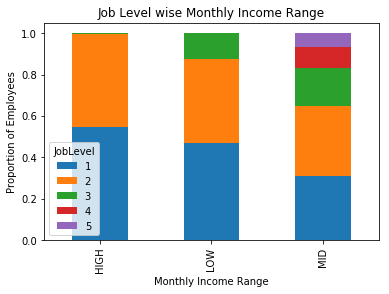

In [43]:
#print(df_merge_attrition_department.Attrition.count())
table=pd.crosstab(df_merge_attrition.MnthlyIncRange, df_merge_attrition.JobLevel)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Job Level wise Monthly Income Range')
plt.xlabel('Monthly Income Range')
plt.ylabel('Proportion of Employees')

Text(0, 0.5, 'Proportion of Employees')

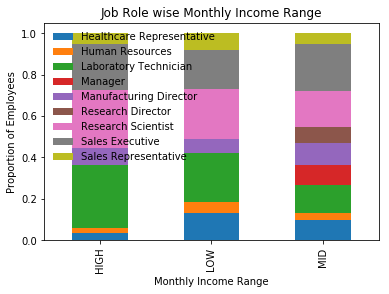

In [44]:
#print(df_merge_attrition_department.Attrition.count())
table=pd.crosstab(df_merge_attrition.MnthlyIncRange, df_merge_attrition.JobRole)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Job Role wise Monthly Income Range')
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Monthly Income Range')
#plt.ylim(0.0,2.0)
plt.ylabel('Proportion of Employees')

Text(0, 0.5, 'Proportion of Employees')

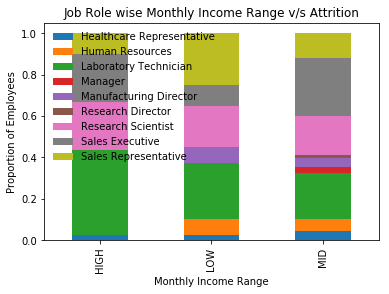

In [45]:
df_merge_attrition_true = df_merge_attrition.loc[df_merge_attrition['Attrition']=='Yes']

table=pd.crosstab(df_merge_attrition_true.MnthlyIncRange, df_merge_attrition_true.JobRole)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Job Role wise Monthly Income Range v/s Attrition')
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Monthly Income Range')
#plt.ylim(0.0,2.0)
plt.ylabel('Proportion of Employees')

In [46]:
print("Percentage Salary Hikes varies from {}% to {}%.".format(
    attrition['PercentSalaryHike'].min(), attrition['PercentSalaryHike'].max()))

Percentage Salary Hikes varies from 11% to 25%.


In [47]:
# Add histogram data
x1 = attrition.loc[attrition['Attrition'] == 'No', 'PercentSalaryHike']
x2 = attrition.loc[attrition['Attrition'] == 'Yes', 'PercentSalaryHike']
# Group data together
hist_data = [x1, x2]
group_labels = ['Active Employees', 'Ex-Employees']
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,
                         curve_type='kde', show_hist=False, show_rug=False)
# Add title
fig['layout'].update(title='Percent Salary Hike by Attrition Status')
fig['layout'].update(xaxis=dict(range=[attrition['PercentSalaryHike'].min(), attrition['PercentSalaryHike'].max()], dtick=1))
# Plot
off.iplot(fig, filename='Distplot with Multiple Datasets')

In [48]:
attrition['Attrition'].iplot(kind='hist', xTitle='Attrition',
                         yTitle='count', title='Attrition Distribution')

In [49]:
print("Percentage of Current Employees is {:.1f}% and of Ex-employees is: {:.1f}%".format(
    attrition[attrition['Attrition'] == 'No'].shape[0] *100/ attrition.shape[0],
    attrition[attrition['Attrition'] == 'Yes'].shape[0] *100/ attrition.shape[0]))

Percentage of Current Employees is 83.9% and of Ex-employees is: 16.1%


In [50]:
# Find correlations with the target and sort
df_HR_trans = df_merge_attrition.copy()
df_HR_trans['Target'] = df_HR_trans['Attrition'].apply(
    lambda x: 0 if x == 'No' else 1)
df_HR_trans = df_HR_trans.drop(
    ['Attrition', 'EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis=1)
correlations = df_HR_trans.corr()['Target'].sort_values()
print('Most Positive Correlations: \n', correlations.tail(5))
print('\nMost Negative Correlations: \n', correlations.head(5))

Most Positive Correlations: 
 PerformanceRating     0.002889
MonthlyRate           0.015170
NumCompaniesWorked    0.043494
DistanceFromHome      0.077924
Target                1.000000
Name: Target, dtype: float64

Most Negative Correlations: 
 TotalWorkingYears    -0.171063
JobLevel             -0.169105
YearsInCurrentRole   -0.160545
MonthlyIncome        -0.159840
Age                  -0.159205
Name: Target, dtype: float64


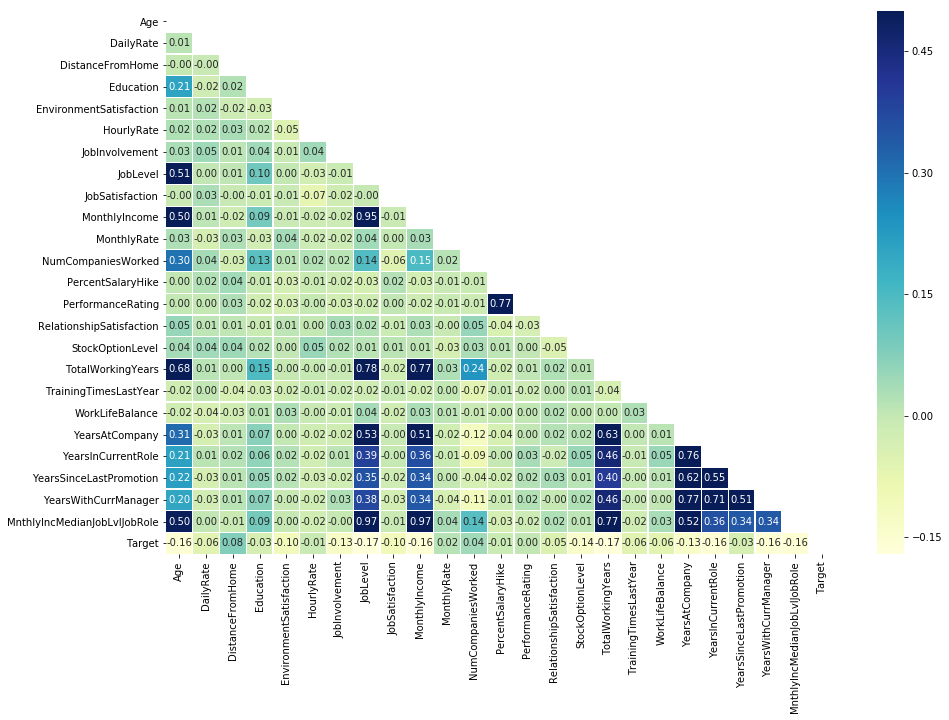

In [51]:
corr = df_HR_trans.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr,
            vmax=.5,
            mask=mask,
            annot=True, fmt='.2f',
            linewidths=.2, cmap="YlGnBu")

As shown above, "Monthly Rate", "Number of Companies Worked" and "Distance From Home" are positively correlated to Attrition; 
while "Total Working Years", "Job Level", and "Years In Current Role" are negatively correlated to Attrition.

EDA Concluding Remarks
Let's summarise the findings from this EDA: 

The dataset does not feature any missing or erroneous data values, and all features are of the correct data type.

The strongest positive correlations with the target features are: Performance Rating, Monthly Rate, Num Companies Worked, Distance From Home.

The strongest negative correlations with the target features are: Total Working Years, Job Level, Years In Current Role, and Monthly Income.

The dataset is imbalanced with the majoriy of observations describing Currently Active Employees. 

Several features (ie columns) are redundant for our analysis, namely: EmployeeCount, EmployeeNumber, StandardHours, and Over18. 
Other observations include: 

Single employees show the largest proportion of leavers, compared to Married and Divorced counterparts. 

About 10% of leavers left when they reach their 2-year anniversary at the company. 

Loyal employees with higher salaries and more responsbilities show lower proportion of leavers compared to their counterparts.

People who live further away from their work show higher proportion of leavers compared to their counterparts.

People who travel frequently show higher proportion of leavers compared to their counterparts.

People who have to work overtime show higher proportion of leavers compared to their counterparts.

Employee who work as Sales Representatives show a significant percentage of Leavers in the submitted dataset.

Employees that have already worked at several companies previously (already "bounced" between workplaces) show higher proportion of leavers compared to their counterparts.


# Pre Processing


In this section, we undertake data pre-processing steps to prepare the datasets for Machine Learning algorithm implementation.

Label Encoding

Lots of machine learning algorithms require numerical input data, so you need to represent categorical columns in a numerical column.Hence Label Encoding becomes necessary as they encode categorical labels with numerical values.

In [52]:
!pip install xgboost

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [53]:
# sklearn modules for preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from imblearn.over_sampling import SMOTE  # SMOTE
# sklearn modules for ML model selection
from sklearn.model_selection import train_test_split  # import 'train_test_split'
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Libraries for data modelling
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Common sklearn Model Helpers
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
# from sklearn.datasets import make_classification

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score

In [54]:
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Create a label encoder object
le = LabelEncoder()

In [55]:
print(df_HR_trans.shape)
df_HR_trans.head()

(1470, 33)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,MnthlyIncMedianJobLvlJobRole,MnthlyIncRange,Target
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5,5454.0,MID,1
1,42,Travel_Rarely,691,Sales,8,4,Marketing,3,Male,48,3,2,Sales Executive,2,Married,6825,21173,0,No,11,3,4,1,10,2,3,9,7,4,2,5454.0,HIGH,0
2,33,Travel_Frequently,1141,Sales,1,3,Life Sciences,3,Female,42,4,2,Sales Executive,1,Married,5376,3193,2,No,19,3,1,2,10,3,3,5,3,1,3,5454.0,MID,0
3,34,Non-Travel,1065,Sales,23,4,Marketing,2,Male,72,3,2,Sales Executive,3,Single,4568,10034,0,No,20,4,3,0,10,2,3,9,5,8,7,5454.0,MID,0
4,46,Travel_Frequently,1211,Sales,5,4,Marketing,1,Male,98,3,2,Sales Executive,4,Single,5772,20445,4,Yes,21,4,3,0,14,4,3,9,6,0,8,5454.0,MID,0


In [56]:
#df_HR_trans = df_HR_trans.drop(['DailyRate','HourlyRate','MonthlyRate','MnthlyIncMedianJobLvlJobRole','MonthlyIncome'],axis=1)
df_HR_trans = df_HR_trans.drop(['DailyRate','HourlyRate','MonthlyRate','MnthlyIncMedianJobLvlJobRole'],axis=1)
df_HR_trans.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,MnthlyIncRange,Target
0,41,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,2,Sales Executive,4,Single,5993,8,Yes,11,3,1,0,8,0,1,6,4,0,5,MID,1
1,42,Travel_Rarely,Sales,8,4,Marketing,3,Male,3,2,Sales Executive,2,Married,6825,0,No,11,3,4,1,10,2,3,9,7,4,2,HIGH,0
2,33,Travel_Frequently,Sales,1,3,Life Sciences,3,Female,4,2,Sales Executive,1,Married,5376,2,No,19,3,1,2,10,3,3,5,3,1,3,MID,0
3,34,Non-Travel,Sales,23,4,Marketing,2,Male,3,2,Sales Executive,3,Single,4568,0,No,20,4,3,0,10,2,3,9,5,8,7,MID,0
4,46,Travel_Frequently,Sales,5,4,Marketing,1,Male,3,2,Sales Executive,4,Single,5772,4,Yes,21,4,3,0,14,4,3,9,6,0,8,MID,0


In [57]:
le_count = 0
for col in df_HR_trans.columns[1:]:
    if df_HR_trans[col].dtype == 'object':
        if len(list(df_HR_trans[col].unique())) <= 2:
            print(col)
            le.fit(df_HR_trans[col])
            df_HR_trans[col] = le.transform(df_HR_trans[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))


Gender
OverTime
2 columns were label encoded.


In [58]:
# convert rest of categorical variable into dummy
df_HR_trans = pd.get_dummies(df_HR_trans, drop_first=False)
print(df_HR_trans.shape)
df_HR_trans.head()

(1470, 50)


,Age,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Target,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MnthlyIncRange_HIGH,MnthlyIncRange_LOW,MnthlyIncRange_MID
0,41,1,2,2,0,3,2,4,5993,8,1,11,3,1,0,8,0,1,6,4,0,5,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,42,8,4,3,1,3,2,2,6825,0,0,11,3,4,1,10,2,3,9,7,4,2,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
2,33,1,3,3,0,4,2,1,5376,2,0,19,3,1,2,10,3,3,5,3,1,3,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
3,34,23,4,2,1,3,2,3,4568,0,0,20,4,3,0,10,2,3,9,5,8,7,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,46,5,4,1,1,3,2,4,5772,4,1,21,4,3,0,14,4,3,9,6,0,8,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1


In [59]:
df_HR_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 0 to 1469
Data columns (total 50 columns):
Age                                  1470 non-null int64
DistanceFromHome                     1470 non-null int64
Education                            1470 non-null int64
EnvironmentSatisfaction              1470 non-null int64
Gender                               1470 non-null int64
JobInvolvement                       1470 non-null int64
JobLevel                             1470 non-null int64
JobSatisfaction                      1470 non-null int64
MonthlyIncome                        1470 non-null int64
NumCompaniesWorked                   1470 non-null int64
OverTime                             1470 non-null int64
PercentSalaryHike                    1470 non-null int64
PerformanceRating                    1470 non-null int64
RelationshipSatisfaction             1470 non-null int64
StockOptionLevel                     1470 non-null int64
TotalWorkingYears                    1

In [60]:
# import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 5))
HR_col = list(df_HR_trans.columns)
HR_col.remove('Target')
for col in HR_col:
    df_HR_trans[col] = df_HR_trans[col].astype(float)
    df_HR_trans[[col]] = scaler.fit_transform(df_HR_trans[[col]])
df_HR_trans['Target'] = pd.to_numeric(df_HR_trans['Target'], downcast='float')
df_HR_trans.head()

,Age,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Target,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MnthlyIncRange_HIGH,MnthlyIncRange_LOW,MnthlyIncRange_MID
0,2.738095,0.000000,1.25,1.666667,0.0,3.333333,1.25,5.000000,1.312270,4.444444,5.0,0.000000,0.0,0.000000,0.000000,1.00,0.000000,0.000000,0.750,1.111111,0.000000,1.470588,1.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0
1,2.857143,1.250000,3.75,3.333333,5.0,3.333333,1.25,1.666667,1.531332,0.000000,0.0,0.000000,0.0,5.000000,1.666667,1.25,1.666667,3.333333,1.125,1.944444,1.333333,0.588235,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0
2,1.785714,0.000000,2.50,3.333333,0.0,5.000000,1.25,0.000000,1.149816,1.111111,0.0,2.857143,0.0,0.000000,3.333333,1.25,2.500000,3.333333,0.625,0.833333,0.333333,0.882353,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0
3,1.904762,3.928571,3.75,1.666667,5.0,3.333333,1.25,3.333333,0.937072,0.000000,0.0,3.214286,5.0,3.333333,0.000000,1.25,1.666667,3.333333,1.125,1.388889,2.666667,2.058824,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0
4,3.333333,0.714286,3.75,0.000000,5.0,3.333333,1.25,5.000000,1.254081,2.222222,5.0,3.571429,5.0,3.333333,0.000000,1.75,3.333333,3.333333,1.125,1.666667,0.000000,2.352941,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0


In [61]:
model_data = df_HR_trans.copy()
cols = list(model_data.columns)
cols.remove('Target')
for col in cols:
    model_data[col] = model_data[col]
    model_data['Target'] = pd.to_numeric(df_HR_trans['Target'], downcast='integer')

model_data = model_data.reindex(columns=sorted(model_data.columns))
model_data = model_data.reindex(columns=(['Target'] + list([a for a in model_data.columns if a != 'Target']) ))
model_data.head()

,Target,Age,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,DistanceFromHome,Education,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MnthlyIncRange_HIGH,MnthlyIncRange_LOW,MnthlyIncRange_MID,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,2.738095,0.0,0.0,5.0,0.0,0.0,5.0,0.000000,1.25,0.0,5.0,0.0,0.0,0.0,0.0,1.666667,0.0,3.333333,1.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.000000,0.0,0.0,5.0,0.0,0.0,5.0,1.312270,4.444444,5.0,0.000000,0.0,0.000000,0.000000,1.00,0.000000,0.000000,0.750,1.111111,0.000000,1.470588
1,0,2.857143,0.0,0.0,5.0,0.0,0.0,5.0,1.250000,3.75,0.0,0.0,5.0,0.0,0.0,0.0,3.333333,5.0,3.333333,1.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.666667,0.0,5.0,0.0,5.0,0.0,0.0,1.531332,0.000000,0.0,0.000000,0.0,5.000000,1.666667,1.25,1.666667,3.333333,1.125,1.944444,1.333333,0.588235
2,0,1.785714,0.0,5.0,0.0,0.0,0.0,5.0,0.000000,2.50,0.0,5.0,0.0,0.0,0.0,0.0,3.333333,0.0,5.000000,1.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.000000,0.0,5.0,0.0,0.0,0.0,5.0,1.149816,1.111111,0.0,2.857143,0.0,0.000000,3.333333,1.25,2.500000,3.333333,0.625,0.833333,0.333333,0.882353
3,0,1.904762,5.0,0.0,0.0,0.0,0.0,5.0,3.928571,3.75,0.0,0.0,5.0,0.0,0.0,0.0,1.666667,5.0,3.333333,1.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.333333,0.0,0.0,5.0,0.0,0.0,5.0,0.937072,0.000000,0.0,3.214286,5.0,3.333333,0.000000,1.25,1.666667,3.333333,1.125,1.388889,2.666667,2.058824
4,0,3.333333,0.0,5.0,0.0,0.0,0.0,5.0,0.714286,3.75,0.0,0.0,5.0,0.0,0.0,0.0,0.000000,5.0,3.333333,1.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.000000,0.0,0.0,5.0,0.0,0.0,5.0,1.254081,2.222222,5.0,3.571429,5.0,3.333333,0.000000,1.75,3.333333,3.333333,1.125,1.666667,0.000000,2.352941


In [62]:
print(model_data.shape)

(1470, 50)


In [63]:
# assign the target to a new dataframe and convert it to a numerical feature
#df_target = df_HR[['Attrition']].copy()
target = df_HR_trans['Target'].copy()
df_HR_trans.drop(['Target'], axis=1, inplace=True)
print('Size of Full dataset is: {}'.format(df_HR_trans.shape))

Size of Full dataset is: (1470, 49)


In [64]:
# Since we have class imbalance (i.e. more employees with turnover=0 than turnover=1)
# let's use stratify=y to maintain the same ratio as in the training dataset when splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df_HR_trans,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    stratify=target)  
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1102, 49)
Number transactions y_train dataset:  (1102,)
Number transactions X_test dataset:  (368, 49)
Number transactions y_test dataset:  (368,)


In [65]:
# selection of algorithms to consider and set performance measure
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state=7,
                                                         class_weight='balanced')))
models.append(('Random Forest', RandomForestClassifier(
    n_estimators=100, random_state=7)))
models.append(('SVM', SVC(gamma='auto', random_state=7)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier',
               DecisionTreeClassifier(random_state=7)))
models.append(('Gaussian NB', GaussianNB()))

In [66]:
acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=col)
i = 0
# evaluate each model using cross-validation
for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10, random_state=7)  # 10-fold cross-validation

    cv_acc_results = model_selection.cross_val_score(  # accuracy scoring
        model, X_train, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(  # roc_auc scoring
        model, X_train, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
0,Logistic Regression,81.81,4.97,73.95,3.13
1,Random Forest,80.65,5.93,85.93,3.91
2,SVM,76.80,7.46,83.75,4.30
5,Gaussian NB,74.08,5.02,63.69,6.67
3,KNN,62.84,6.07,83.67,3.88
4,Decision Tree Classifier,60.39,4.93,77.32,3.05


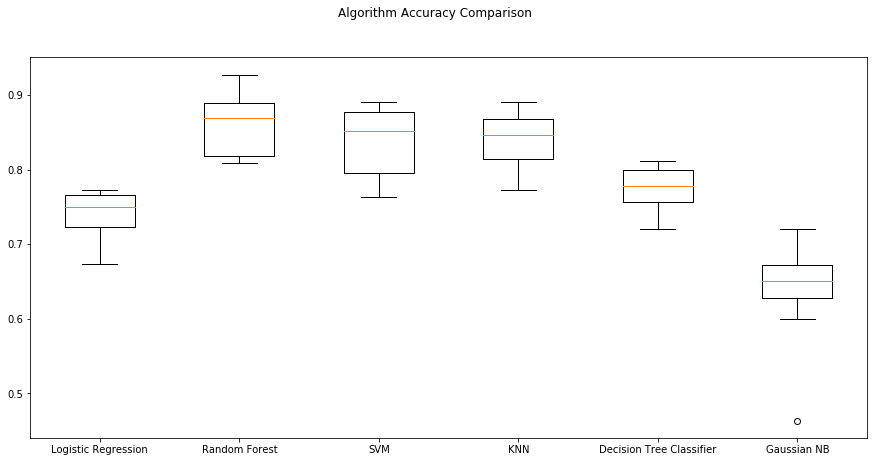

In [67]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()

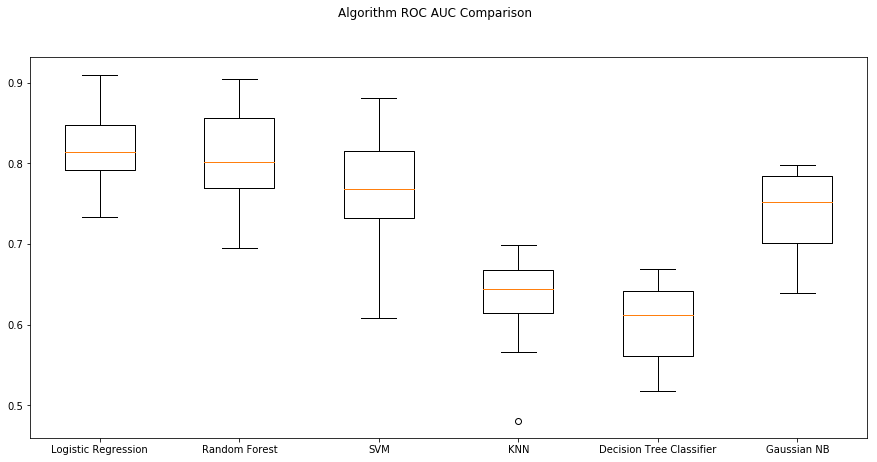

In [68]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm ROC AUC Comparison')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.show()

In [69]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression(solver='liblinear',
                             class_weight="balanced", 
                             random_state=7)
scoring = 'roc_auc'
results = model_selection.cross_val_score(
    modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("AUC score (STD): %.2f (%.2f)" % (results.mean(), results.std()))

AUC score (STD): 0.82 (0.05)


In [70]:
param_grid = {'C': np.arange(1e-03, 2, 0.01)} # hyper-parameter list to fine-tune
log_gs = GridSearchCV(LogisticRegression(solver='liblinear', # setting GridSearchCV
                                         class_weight="balanced", 
                                         random_state=7),
                      iid=True,
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

log_grid = log_gs.fit(X_train, y_train)
log_opt = log_grid.best_estimator_
results = log_gs.cv_results_

print('='*20)
print("best params: " + str(log_gs.best_estimator_))
print("best params: " + str(log_gs.best_params_))
print('best score:', log_gs.best_score_)
print('='*20)

best params: LogisticRegression(C=1.9509999999999996, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
best params: {'C': 1.9509999999999996}
best score: 0.8145980336340701


Text(0.5, 257.44, 'Predicted label')

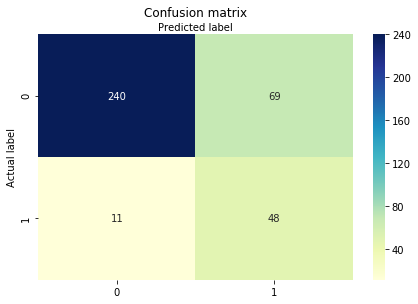

In [71]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, log_opt.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [72]:
print('Accuracy of Logistic Regression Classifier on test set: {:.2f}'.format(log_opt.score(X_test, y_test)*100))

Accuracy of Logistic Regression Classifier on test set: 78.26


In [73]:
# Classification report for the optimised Log Regression
log_opt.fit(X_train, y_train)
print(classification_report(y_test, log_opt.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86       309
         1.0       0.41      0.81      0.55        59

    accuracy                           0.78       368
   macro avg       0.68      0.80      0.70       368
weighted avg       0.87      0.78      0.81       368



In [74]:
log_opt.fit(X_train, y_train) # fit optimised model to the training data
probs = log_opt.predict_proba(X_test) # predict probabilities
probs = probs[:, 1] # we will only keep probabilities associated with the employee leaving
logit_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
print('AUC score: %.3f' % logit_roc_auc)

AUC score: 0.866


In [75]:
rf_classifier = RandomForestClassifier(class_weight = "balanced",
                                       random_state=7)
#param_grid = {'n_estimators': [50, 75, 100, 125, 150, 175],
#              'min_samples_split':[2,4,6,8,10],
#              'min_samples_leaf': [1, 2, 3, 4],
#             'max_depth': [5, 10, 15, 20, 25]}
param_grid = {'n_estimators': [50, 75, 100],
              'min_samples_split':[2,4,6,8],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_depth': [5, 10, 15, 20, 25]}

grid_obj = GridSearchCV(rf_classifier,
                        iid=True,
                        return_train_score=True,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=10)

grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_

print('='*20)
print("best params: " + str(grid_obj.best_estimator_))
print("best params: " + str(grid_obj.best_params_))
print('best score:', grid_obj.best_score_)
print('='*20)

best params: RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=8, min_weight_fraction_leaf=0.0,
                       n_estimators=75, n_jobs=None, oob_score=False,
                       random_state=7, verbose=0, warm_start=False)
best params: {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 75}
best score: 0.8126856521637648


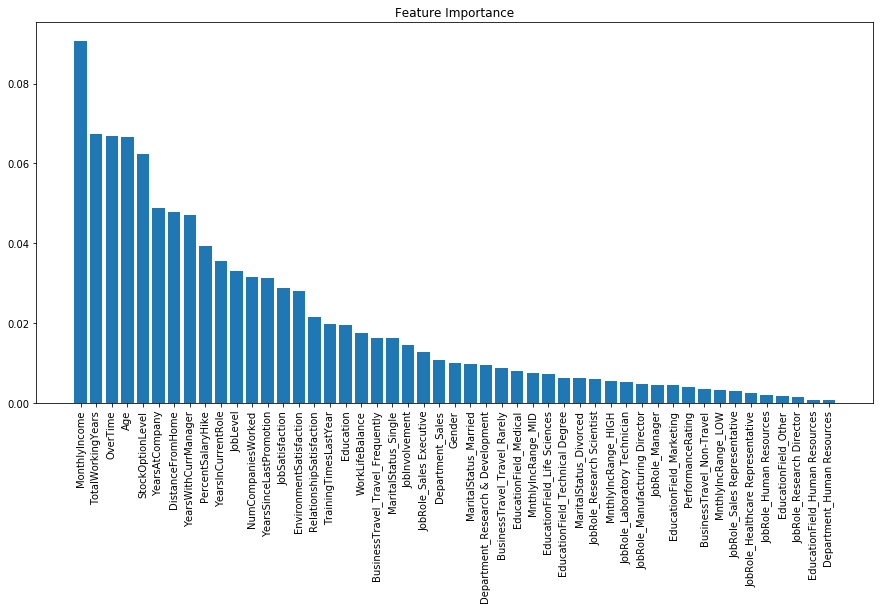

In [76]:
importances = rf_opt.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

Text(0.5, 257.44, 'Predicted label')

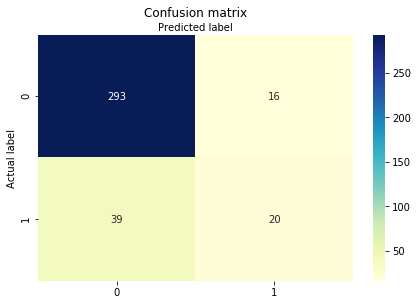

In [77]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, rf_opt.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [78]:
print('Accuracy of RandomForest Regression Classifier on test set: {:.2f}'.format(rf_opt.score(X_test, y_test)*100))

Accuracy of RandomForest Regression Classifier on test set: 85.05


In [79]:
# Classification report for the optimised RF Regression
rf_opt.fit(X_train, y_train)
print(classification_report(y_test, rf_opt.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91       309
         1.0       0.56      0.34      0.42        59

    accuracy                           0.85       368
   macro avg       0.72      0.64      0.67       368
weighted avg       0.83      0.85      0.84       368



In [80]:
rf_opt.fit(X_train, y_train) # fit optimised model to the training data
probs = rf_opt.predict_proba(X_test) # predict probabilities
probs = probs[:, 1] # we will only keep probabilities associated with the employee leaving
rf_opt_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
print('AUC score: %.3f' % rf_opt_roc_auc)

AUC score: 0.793


In [81]:
#Import Gradient Boosting Classifier model
from sklearn.ensemble import GradientBoostingClassifier

#Create Gradient Boosting Classifier
gb = GradientBoostingClassifier()

#Train the model using the training sets
gb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gb.predict(X_test)

In [82]:
probs = gb.predict_proba(X_test) # predict probabilities
probs = probs[:, 1] # we will only keep probabilities associated with the employee leaving
gb_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
print('AUC score: %.3f' % rf_opt_roc_auc)

AUC score: 0.793


In [83]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8505434782608695
Precision: 0.5625
Recall: 0.3050847457627119


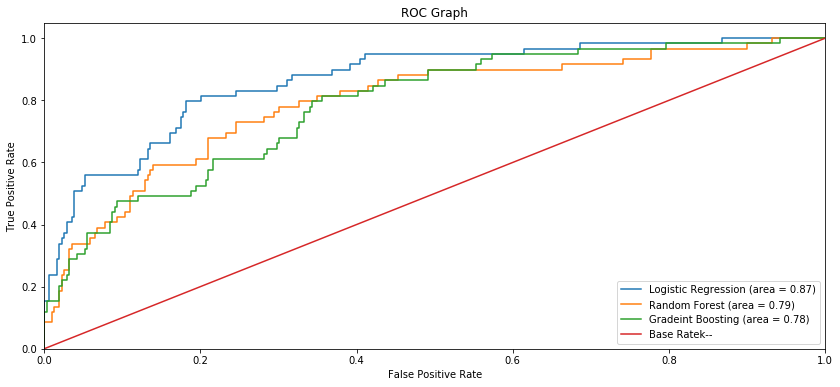

In [84]:
# Create ROC Graph
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, log_opt.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_opt.predict_proba(X_test)[:,1])
gb_fpr,gb_tpr,gb_thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_opt_roc_auc)
# Plot GradientBossting ROC
plt.plot(gb_fpr, gb_tpr, label='Gradeint Boosting (area = %0.2f)' % gb_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features.

In [85]:
from sklearn.utils import resample

In [86]:
#!pip install -U scikit-learn

In [87]:
#!pip install imblearn
!pip install -U imbalanced-learn
#conda install -c glemaitre imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (0.5.0)
Requirement not upgraded as not directly required: joblib>=0.11 in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (from imbalanced-learn) (0.13.2)
Requirement not upgraded as not directly required: numpy>=1.11 in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (from imbalanced-learn) (1.14.3)
Requirement not upgraded as not directly required: scipy>=0.17 in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (from imbalanced-learn) (1.1.0)
Requirement not upgraded as not directly required: scikit-learn>=0.21 in /home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages (from imbalanced-learn) (0.21.3)
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [88]:
import imblearn

In [89]:
def plot_2d_space(X, y, label='Targets'):   
    #colors = ['#1F77B4', '#FF7F0E']
    colors = ['g', 'r']
    markers = ['o', 'o']
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    for l, c, m in zip(np.unique(y), colors, markers):
        ax.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, s=50
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [90]:
from sklearn.decomposition import PCA

model_data_1 = model_data.copy()
target_1 = model_data_1['Target'].copy()
model_data_1.drop(['Target'], axis=1, inplace=True)

pca = PCA(n_components=49)
model_data_tmp = pca.fit_transform(model_data_1)

#principalDf = pd.DataFrame(data = model_data_tmp
#             , columns = ['principal component 1', 'principal component 2'])
#principalDf

#plot_2d_space(model_data, df_majority['Target'], 'Imbalanced dataset (2 PCA components)')

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

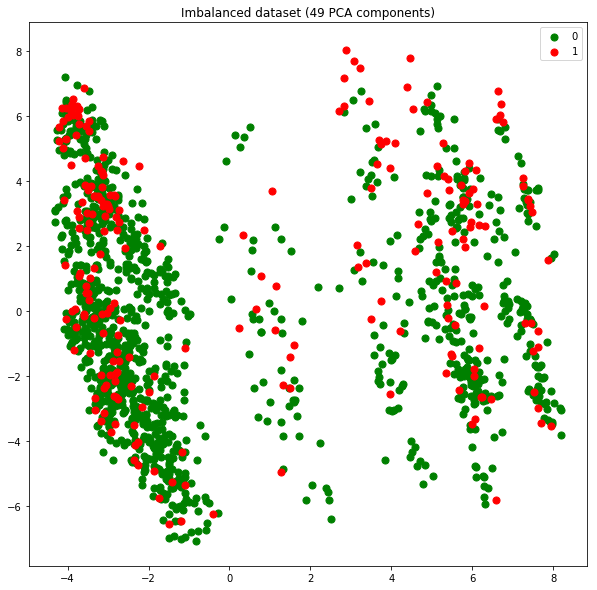

In [91]:
plot_2d_space(model_data_tmp, target_1, 'Imbalanced dataset (49 PCA components)')

In [92]:
model_data_upsampled = df_upsampled.copy()
target_upsampled = model_data_upsampled['Target'].copy()
model_data_upsampled.drop(['Target'], axis=1, inplace=True)

pca = PCA(n_components=49)
model_data_upsampled_tmp = pca.fit_transform(model_data_upsampled)


NameError: name 'df_upsampled' is not defined

In [ ]:
plot_2d_space(model_data_upsampled_tmp, target_upsampled, 'Upsampled dataset (49 PCA components)')

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(model_data_tmp, target_1)

print(X_ros.shape[0] - model_data_tmp.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(model_data_tmp, target_1)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(model_data_tmp, target_1)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [93]:
#train_data, validation_data, test_data = np.split(df_upsampled.sample(frac=1, random_state=1470), [int(0.7 * len(df_upsampled)), int(0.9 * len(df_upsampled))])
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1470), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
#validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1470), [int(0.6 * len(model_data))])
#train_data.to_csv('train.csv', header=False, index=False)

In [94]:
train_data.Target.value_counts()

0    860
1    169
Name: Target, dtype: int64

In [215]:
validation_data.Target.value_counts()

0    253
1     41
Name: Target, dtype: int64

In [216]:
test_data.Target.value_counts()

0    120
1     27
Name: Target, dtype: int64

In [95]:
df_majority = train_data[train_data.Target==0]
df_minority = train_data[train_data.Target==1]

df_majority.Target.value_counts()
df_minority.Target.value_counts()

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=860,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
#df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_upsampled = pd.concat([df_majority, df_minority_upsampled]) 
# Display new class counts
df_upsampled.Target.value_counts()

1    860
0    860
Name: Target, dtype: int64

In [96]:
from sklearn.decomposition import PCA

train_data_1 = train_data.copy()
train_target_1 = train_data_1['Target'].copy()
train_data_1.drop(['Target'], axis=1, inplace=True)

pca = PCA(n_components=49)
train_data_tmp = pca.fit_transform(train_data_1)

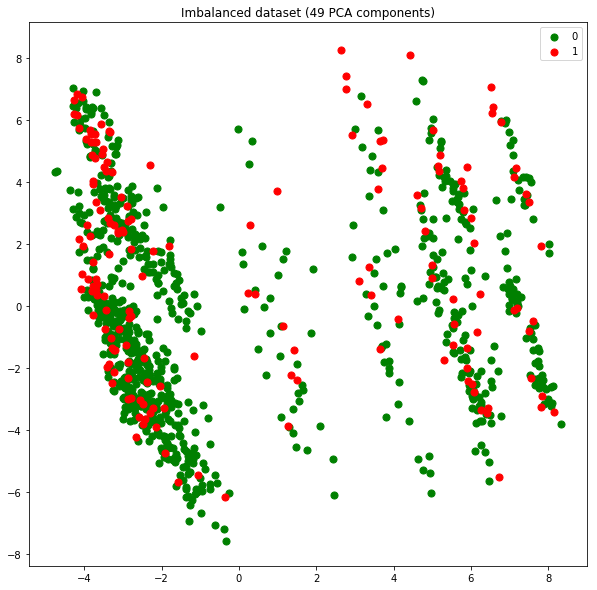

In [97]:
plot_2d_space(train_data_tmp, train_target_1, 'Imbalanced dataset (49 PCA components)')

In [98]:
upsampled_data_1 = df_upsampled.copy()
upsampled_target_1 = upsampled_data_1['Target'].copy()
upsampled_data_1.drop(['Target'], axis=1, inplace=True)

pca = PCA(n_components=49)
upsampled_data_tmp = pca.fit_transform(upsampled_data_1)

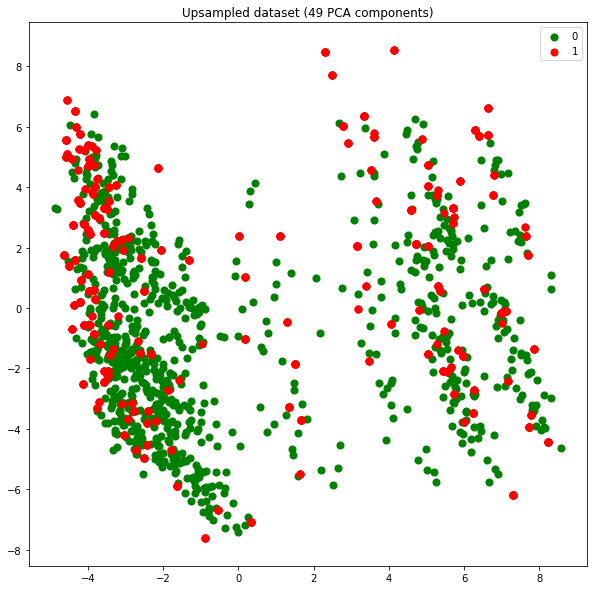

In [99]:
plot_2d_space(upsampled_data_tmp, upsampled_target_1, 'Upsampled dataset (49 PCA components)')

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(train_data_tmp, train_target_1)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [100]:
#Import Gradient Boosting Classifier model
from sklearn.ensemble import GradientBoostingClassifier

#Create Gradient Boosting Classifier
gb = GradientBoostingClassifier()

#Train the model using the training sets
gb.fit(upsampled_data_1, upsampled_target_1)

#Predict the response for test dataset
y_pred = gb.predict(X_test)

In [101]:
probs = gb.predict_proba(X_test) # predict probabilities
probs = probs[:, 1] # we will only keep probabilities associated with the employee leaving
gb_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
print('AUC score: %.3f' % gb_roc_auc)

AUC score: 0.615


In [102]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.20923913043478262
Precision: 0.16279069767441862
Recall: 0.9491525423728814


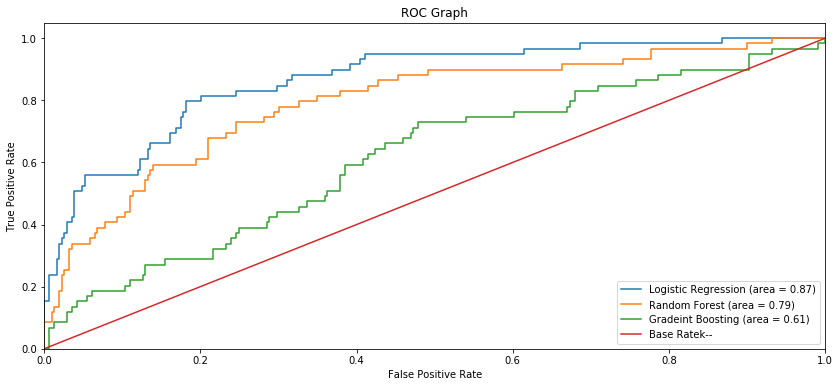

In [103]:
# Create ROC Graph
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, log_opt.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_opt.predict_proba(X_test)[:,1])
gb_fpr,gb_tpr,gb_thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_opt_roc_auc)
# Plot GradientBossting ROC
plt.plot(gb_fpr, gb_tpr, label='Gradeint Boosting (area = %0.2f)' % gb_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

df=pd.DataFrame(data=X_smt[0:,0:],
            index=[i for i in range(X_smt.shape[0])],
            columns=['f'+str(i) for i in range(X_smt.shape[1])])

df.head()

y_series = pd.Series(y_smt, name='Target')
result = pd.concat([y_series,df], axis=1)
result

result.Target.value_counts()

In [233]:
df_upsampled.Target.value_counts()

1    860
0    860
Name: Target, dtype: int64

In [234]:
#result.to_csv('train.csv', header=False, index=False)
df_upsampled.to_csv('train.csv', header=False, index=False)
#validation_data.to_csv('validation.csv', header=False, index=False)
#train_data.to_csv('train.csv', header=False, index=False)
#train_data


In [235]:
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [236]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [237]:
from sagemaker.amazon.amazon_estimator import get_image_uri

In [238]:
container_1 = get_image_uri(boto3.Session().region_name, 'linear-learner')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [239]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='text/csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [240]:
linearReg = sagemaker.estimator.Estimator(container_1,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
linearReg.set_hyperparameters(feature_dim=49,
                           predictor_type='binary_classifier',normalize_data=False,
                             binary_classifier_model_selection_criteria='f_beta')

linearReg.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-09-08 22:16:31 Starting - Starting the training job...
2019-09-08 22:16:32 Starting - Launching requested ML instances......
2019-09-08 22:17:32 Starting - Preparing the instances for training......
2019-09-08 22:18:37 Downloading - Downloading input data...
2019-09-08 22:19:32 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[09/08/2019 22:19:34 INFO 140543786383168] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': 

#metrics {"Metrics": {"validation_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5922096927149766, "sum": 0.5922096927149766, "min": 0.5922096927149766}}, "EndTime": 1567981177.154096, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1567981177.154}

#metrics {"Metrics": {"validation_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6025231290025775, "sum": 0.6025231290025775, "min": 0.6025231290025775}}, "EndTime": 1567981177.154191, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1567981177.154174}

#metrics {"Metrics": {"validation_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.5914668907113627, "sum": 0.5914668907113627, "min": 0.5914668907113627}}, "EndTime": 1567981177.154254, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "L


2019-09-08 22:19:49 Uploading - Uploading generated training model
2019-09-08 22:19:49 Completed - Training job completed
Billable seconds: 73


sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

In [ ]:
linear_predictor = linearReg.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

-------------------------------------------------------------

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [ ]:
#train_data[0]
train_dataArray = train_data.as_matrix()
# get all columns except 0th column
slice=train_dataArray[:,1:50] 
slice.shape
slice

In [ ]:
#get 1st row only
s=slice[1:2]
result = linear_predictor.predict(s)
print(result)

---
## Compile
[Amazon SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) optimizes models to run up to twice as fast, with no loss in accuracy. When calling `compile_model()` function, we specify the target instance family (m4) as well as the S3 bucket to which the compiled model would be stored.

compiled_model = xgb
try:
    xgb.create_model()._neo_image_account(boto3.Session().region_name)
except:
    print('Neo is not currently supported in', boto3.Session().region_name)
else:
    output_path = '/'.join(xgb.output_path.split('/')[:-1])
    compiled_model = xgb.compile_model(target_instance_family='ml_m4', 
                                   input_shape={'data':[1, 50]},
                                   role=role,
                                   framework='xgboost',
                                   framework_version='0.7',
                                   output_path=output_path)
    compiled_model.name = 'deployed-xgboost-employee-attrition'
    compiled_model.image = get_image_uri(sess.boto_region_name, 'xgboost-neo', repo_version='latest')

---
## Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [440]:
xgb_predictor = compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

---------------------------------------------------------------------------------------------------!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [441]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [450]:
def predict(data, rows=100):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

dtest = test_data.as_matrix()
predictions = []
for i in range(dtest.shape[0]):
    predictions.append(predict(dtest[i:i+1, 1:]))
predictions = np.array(predictions).squeeze()

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [182]:
def predict(data, rows=100):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        result = linear_predictor.predict(array)
        print(result)
        predictions = ','.join([predictions, linear_predictor.predict(array)])

    return np.fromstring(predictions[1:], sep=',')

dtest = test_data.as_matrix()
predictions = []
for i in range(dtest.shape[0]):
    predictions.append(predict(dtest[i:i+1, 1:]))
predictions = np.array(predictions).squeeze()

{'predictions': [{'score': 0.0002511240600142628, 'predicted_label': 0.0}]}


/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



TypeError: sequence item 1: expected str instance, dict found

In [ ]:
import numpy as np
dTest = test_data.as_matrix()[:,1:50] 
dTest.shape[0]

In [ ]:
predictions = []
for array in np.array_split(dTest, 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)
predictions

In [ ]:
test_data.as_matrix()[:,0]

In [231]:
import pandas as pd

pd.crosstab(np.where(test_data.as_matrix()[:,0] == 0, 1, 0), predictions, rownames=['actuals'], colnames=['predictions'])

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



predictions,0.0,1.0
actuals,,
0,19,8
1,117,3


In [154]:
import numpy as np

predictions = []
dtest = test_data.as_matrix()
for array in np.array_split(dtest[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from model with message "unable to evaluate payload provided". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/linear-learner-2019-09-08-05-44-10-308 in account 380051601232 for more information.

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a simple confusion matrix.

In [128]:
test_data.Target.value_counts()

0    120
1     27
Name: Target, dtype: int64

In [232]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,117,3
1,19,8


_Note, due to randomized elements of the algorithm, you results may differ slightly._

Of the 48 churners, we've correctly predicted 39 of them (true positives). And, we incorrectly predicted 4 customers would churn who then ended up not doing so (false positives).  There are also 9 customers who ended up churning, that we predicted would not (false negatives).

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting this cutoff.  That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

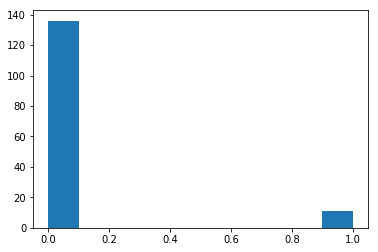

In [213]:
plt.hist(predictions)
plt.show()

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions.  For example...

In [214]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
Target,,
0,117,3
1,19,8


We can see that changing the cutoff from 0.5 to 0.3 results in 1 more true positives, 3 more false positives, and 1 fewer false negatives.  The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff.  Was this the right decision?  We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed.  Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.  Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives.  Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of \$0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume \$500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of \$100. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the \$100 concession. We probably could have spent that \$100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

In [481]:
cutoffs = np.arange(0.01, 0.90, 0.01)
cutoffs
#costs = []
#for c in cutoffs:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.90, 1, 0))

col_0,0,1
Target,,
0,120,0
1,24,3


In [470]:
np.array([[0, 100], [15000, 10000]])

array([[    0,   100],
       [15000, 10000]])

In [473]:
np.array([[0, 100], [15000, 10000]])*pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.01, 1, 0))

col_0,0,1
Target,,
0,0,11100
1,15000,260000


In [472]:
np.sum(np.array([[0, 100], [15000, 10000]])*pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.01, 1, 0)))

col_0
0     15000
1    271100
dtype: int64

In [474]:
np.sum(np.sum(np.array([[0, 100], [15000, 10000]])*pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.01, 1, 0))))

286100

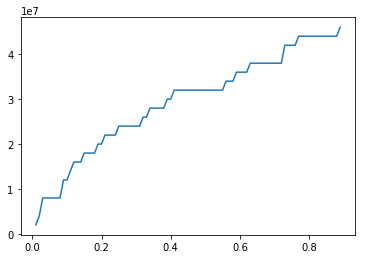

Cost is minimized near a cutoff of: 0.01 for a cost of: 2063100


In [494]:
cutoffs = np.arange(0.01, 0.90, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [2000000, 2000]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive.  Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly.  The overall cost can be minimized at \$8400 by setting the cutoff to 0.46, which is substantially better than the \$20k+ I would expect to lose by not taking any action.

---
## Extensions

This notebook showcased how to build a model that predicts whether a customer is likely to churn, and then how to optimally set a threshold that accounts for the cost of true positives, false positives, and false negatives.  There are several means of extending it including:
- Some customers who receive retention incentives will still churn.  Including a probability of churning despite receiving an incentive in our cost function would provide a better ROI on our retention programs.
- Customers who switch to a lower-priced plan or who deactivate a paid feature represent different kinds of churn that could be modeled separately.
- Modeling the evolution of customer behavior. If usage is dropping and the number of calls placed to Customer Service is increasing, you are more likely to experience churn then if the trend is the opposite. A customer profile should incorporate behavior trends.
- Actual training data and monetary cost assignments could be more complex.
- Multiple models for each type of churn could be needed.

Regardless of additional complexity, similar principles described in this notebook are likely apply.

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [324]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)